In [ ]:
from vehicle import Vehicle
from scipy.optimize import fsolve as josie_solver
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

0.013123872076831914

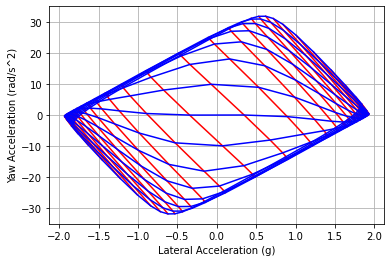

In [2]:
df = pd.read_csv("MMM.csv")

for x in df["body_slip"].unique():
    df2 = df[df["body_slip"] == x]
    plt.plot(df2["y_double_dot"]/9.81, df2["yaw_acceleration"], 'r')
    #plt.text(list(df2["y_double_dot"])[-1]/9.81, list(df2["yaw_acceleration"])[-1], f'sample {x}')

for x in df["steered_angle"].unique():
    df2 = df[(df["steered_angle"] == x)]
    plt.plot(df2["y_double_dot"]/9.81, df2["yaw_acceleration"], 'b')
plt.grid()
plt.ylabel("Yaw Acceleration (rad/s^2)")
plt.xlabel("Lateral Acceleration (g)")

abs(df["yaw_acceleration"]).min()

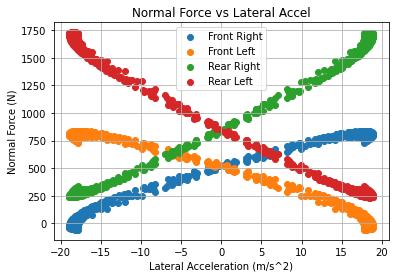

In [3]:
import math
plt.scatter(df["y_double_dot"], df["front_left_tire_centric_forces_2"], label = "Front Right")
plt.scatter(df["y_double_dot"], df["front_right_tire_centric_forces_2"], label = "Front Left")
plt.scatter(df["y_double_dot"], df["rear_left_tire_centric_forces_2"], label = "Rear Right")
plt.scatter(df["y_double_dot"], df["rear_right_tire_centric_forces_2"], label = "Rear Left")
plt.title("Normal Force vs Lateral Accel")
plt.grid()
plt.ylabel("Normal Force (N)")
plt.xlabel("Lateral Acceleration (m/s^2)")
plt.legend()

In [4]:
data_point = df.iloc[100]
for index, point in df.iterrows():
    if abs(point["yaw_acceleration"]) < 5 and abs(point["y_double_dot"]) > abs(data_point["y_double_dot"]):
       data_point = point
print(data_point)

Unnamed: 0                          11.000000
front_left_unsprung_displacement    -0.000377
front_left_tire_centric_forces_0     0.000000
front_left_tire_centric_forces_1    58.470170
front_left_tire_centric_forces_2   -36.385307
                                      ...    
x_double_dot                        -7.197691
y_double_dot                       -18.964340
yaw_acceleration                    -0.353228
roll                                 0.006921
pitch                                0.028475
Name: 11, Length: 71, dtype: float64
